# Data enrichment

This notebook aims to enrich the data to extract interesting metrics on broadcasters who have broadcast at least once with a Vtuber tag. We focus on the data that emanates from the videos available on each broadcaster's channel.

To do this, we first need to query all these videos.

And then we have to understand them at least a little bit.

## For general purpose

In [1]:
import requests
import json
import pandas as pd
import os

 # The .json with the CLIENT_ID and the TOKEN
with open('../twitch_credentials.json', mode='r') as f:
    twitch_credentials = json.load(f)

    # Twitch API variables
    CLIENT_ID = twitch_credentials['CLIENT_ID']
    TOKEN = twitch_credentials['TOKEN']
    
headers = {"Authorization":"Bearer " + TOKEN, "Client-Id":CLIENT_ID}

In [2]:
oldAPIStreams = pd.read_csv('../Data/aggregated/twitch_streams_vtuber_tagIds.csv')
newAPIStreams = pd.read_csv('../Data/aggregated/twitch_streams_vtuber_tagIds_tags.csv')

user_ids_streams = pd.concat([oldAPIStreams, newAPIStreams], ignore_index=True).loc[:, ['user_id']].drop_duplicates()

## Querying videos

In [3]:
from datetime import datetime

url = 'https://api.twitch.tv/helix/videos?first=100&user_id='
ratelimit = []

def get_user_videos(user_df):
    user_id = user_df['user_id'].iloc[0]
    df_response = None
    
    try:
        response = requests.get(url + str(user_id), headers=headers)
        df_response = pd.DataFrame(response.json()["data"])

        ratelimit.append(response.headers['Ratelimit-Remaining'])

        if 'stream_id' not in df_response.columns and not df_response.empty:
            print(f"stream_id not in columns of user {user_id} - 1")
            return None

        # While there are other pages to get
        while len(response.json()["pagination"]) > 0 :
                response = requests.get(url + str(user_id) + "&after=" + response.json()["pagination"]["cursor"], headers=headers)
                df_response = pd.concat([df_response, pd.DataFrame(response.json()["data"])])

                ratelimit.append(response.headers['Ratelimit-Remaining'])

                if 'stream_id' not in df_response.columns:
                    print(f"stream_id not in columns of user {user_id} - 2")
                    return None
        
        return df_response                

    except Exception as e:
        print(f"Exception [{e}] with user {user_id}")
        return None

In [4]:
all_videos = user_ids_streams.groupby('user_id').apply(get_user_videos).reset_index(drop=True)

Just checking the Ratelimit-Remaining to be sure...

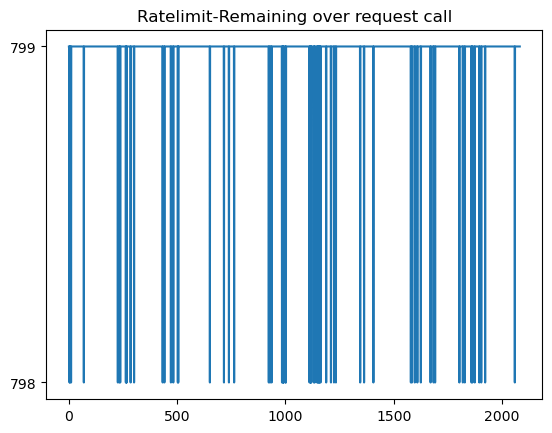

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(ratelimit)), y=ratelimit, )
plt.title('Ratelimit-Remaining over request call');

In [6]:
#all_videos.to_csv('./twitch_videos_vtuber_broadcaster.csv', index=False)

In [7]:
all_videos.groupby("user_name").view_count.sum().sort_values().tail()

user_name
Octoloth       47617.0
vanex_x        59636.0
RavenCross     68580.0
MiyunaTV       80612.0
RiriMiaou     119311.0
Name: view_count, dtype: float64

Just checking the memory size needed to store the dataFrame videos:

In [8]:
import sys

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    all_videos: 34.7 MiB
                 oldAPIStreams:  3.5 MiB
                 newAPIStreams:  2.7 MiB
                     ratelimit: 17.8 KiB
              user_ids_streams: 16.6 KiB
                           _i3:  1.3 KiB
                           _i8:  588.0 B
                             _:  555.0 B
                            _7:  555.0 B
                           _i1:  437.0 B


The idea would be to run a python bot that retrieves the videos every day. And memory is a consideration. With only a few dozen MiB, we are far from any RAM problems.
The python bot is available : [`../TwitchStreamBot/twitch_video_bot.py`](../TwitchStreamBot/twitch_video_bot.py).

In [9]:
# https://api.twitch.tv/helix/users/follows?from_id=26610234&first=1 for getting follower count (see https://discuss.dev.twitch.tv/t/how-do-i-get-follower-count/29247)